<a href="https://www.kaggle.com/code/sgjustino/bbc-news-classification?scriptVersionId=155695774" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/learn-ai-bbc/BBC News Train.csv
/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv
/kaggle/input/learn-ai-bbc/BBC News Test.csv


# Extracting word features and show Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

In [23]:
train_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')

train_data.head()


,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


Initial look shows that there's 3 columns - ArticleId, Text (news content) and Category.

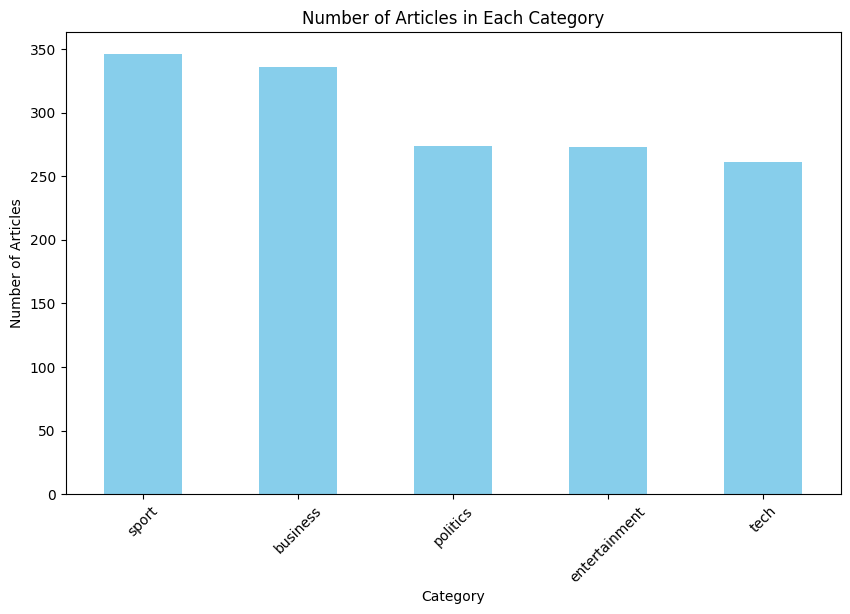

(Category
 sport            346
 business         336
 politics         274
 entertainment    273
 tech             261
 Name: count, dtype: int64,
 count     1490.000000
 mean      2233.461745
 std       1205.153358
 min        501.000000
 25%       1453.000000
 50%       1961.000000
 75%       2751.250000
 max      18387.000000
 Name: text_length, dtype: float64)

In [24]:
import matplotlib.pyplot as plt

category_counts = train_data['Category'].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Articles in Each Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

train_data['text_length'] = train_data['Text'].apply(len)
text_length_stats = train_data['text_length'].describe()

category_counts, text_length_stats


* Sport: 346 articles

* Business: 336 articles

* Politics: 274 articles

* Entertainment: 273 articles

* Tech: 261 articles

The categories are relatively balanced, which is good for training a model as it prevents a significant bias towards a particular class.

Additionally, we analyzed the length of the text in each article. Here are some statistics:

* Mean length: Approximately 2233 characters

* Standard deviation: Approximately 1205 characters

* Minimum length: 501 characters

* Maximum length: 18387 characters

Within each article, there is a wider range of text lengths as seen from the high S.D but otherwise the data appears normal. The mean count also seems reasonable for an article with some possibly high outlier for long article.

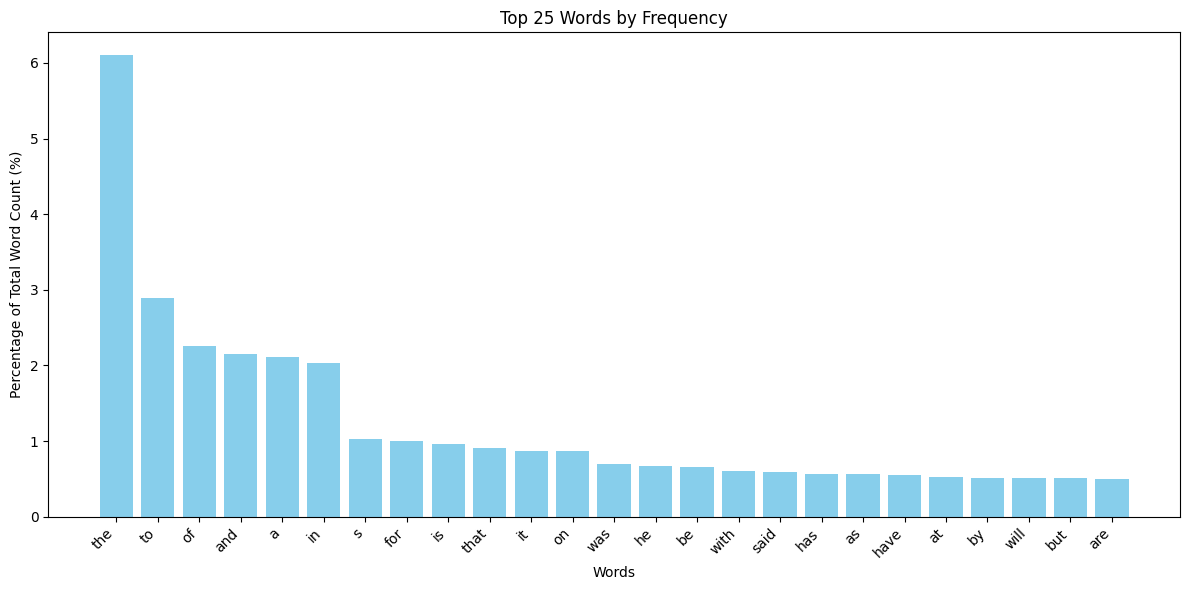

In [25]:

frequency = train_data['Text'].str.split(expand=True).unstack().value_counts()
freqplot = frequency[:25] / np.sum(frequency) * 100

plt.figure(figsize=(12, 6))
plt.bar(freqplot.index, freqplot.values, color='skyblue')
plt.title('Top 25 Words by Frequency')
plt.xlabel('Words')
plt.ylabel('Percentage of Total Word Count (%)')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Looking at the word frequency plot,the % occurrence of the top 25 words are displayed. The word 'the' has a high frequency of 6% which seems pretty understandable. The rest of the words tail off to 1% and are also commonly words used for sentence structuring. Which really brings across the point of the necessity to remove stopwords! Since we are playing with words here, we will end off the initial data examination with a word cloud.

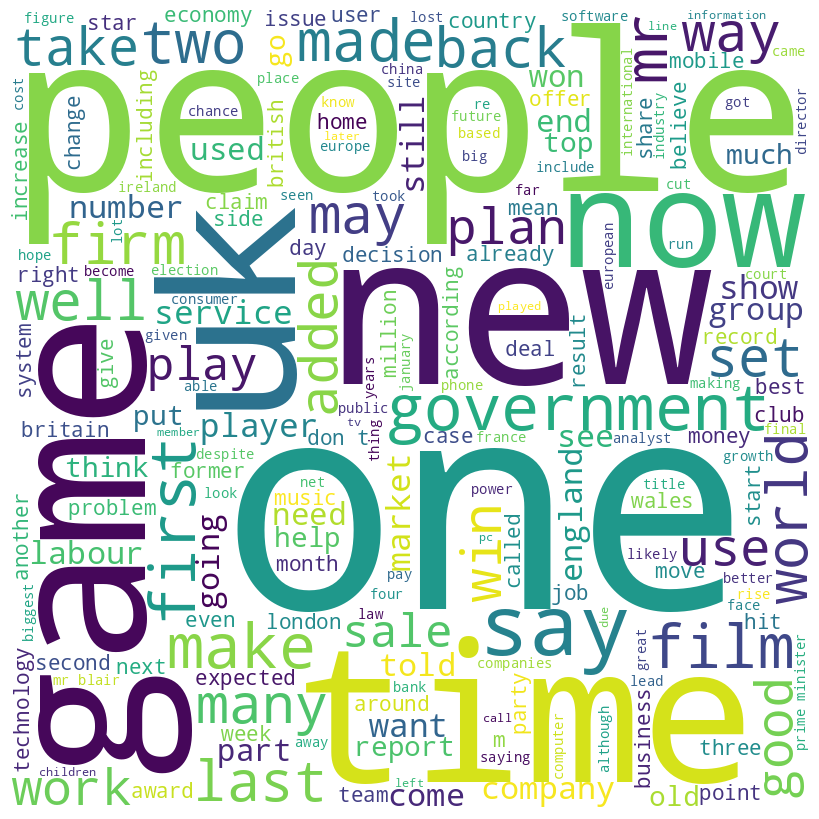

In [26]:
from wordcloud import WordCloud, STOPWORDS

def generate_wordcloud(text_series, additional_stopwords=None, width=800, height=800, background_color='white', min_font_size=10):
    combined_text = ' '.join(text_series.astype(str).str.lower())

    stopwords = set(STOPWORDS)
    if additional_stopwords:
        stopwords.update(additional_stopwords)

    wordcloud = WordCloud(
        width=width, 
        height=height,
        background_color=background_color,
        stopwords=stopwords,
        min_font_size=min_font_size
    ).generate(combined_text)

    plt.figure(figsize=(8, 8), facecolor=None) 
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

additional_stopwords = ["said", "will", "s", "us", "year"]
generate_wordcloud(train_data['Text'], additional_stopwords=additional_stopwords)

Next, we will preprocess the text by cleaning the text data to prepare it for feature extraction. This step includes removing unnecessary special characters (symbols, punctuation etc.), digits, lowercasing, removing stopwords, and lemmatization. 

This data cleaning process help to ensure character encoding consistency, and potentially removing extremely long or short texts that could be considered outliers as seen above. Besides that, we also include text tokenization and normalization. This includes converting the text to lower case and tokenization (splitting the text into words or tokens).

In [27]:
import nltk
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /kaggle/working/...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /kaggle/working/corpora/wordnet.zip


replace /kaggle/working/corpora/wordnet/lexnames? [y]es, [n]o, [A]ll, [N]one, [r]ename:  NULL
(EOF or read error, treating as "[N]one" ...)


In [28]:
import string

def clean_text(doc):
    text = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    
    tokens = nltk.word_tokenize(text.lower())
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    
    return ' '.join(tokens)

train_data['clean_text'] = train_data['Text'].apply(lambda x: clean_text(x))

train_data[['Text', 'clean_text']].head()


,Text,clean_text
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launch defence lawyer defendin...
1,german business confidence slides german busin...,german business confidence slide german busine...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizen majo...
3,lifestyle governs mobile choice faster bett...,lifestyle governs mobile choice faster better ...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...


In the next step, we will utilise the TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization to transform the text data into a matrix of TF-IDF features. 

**TF-IDF**

Nature: TF-IDF is a statistical measure used to evaluate the importance of a word to the article across our dataset. It's not a predictive model but a numerical statistic.

Use Cases: It's commonly used in search engine scoring, text mining, and information retrieval. For example, it can help identify the most relevant documents from a search query or filter out common words that occur across all documents (like "is" or "and").

Output: It results in a weight that highlights words with high relevance to a specific article. This is useful for scoring, ranking, and finding important words across articles.

Methodology: It's calculated by multiplying two metrics: how many times a word appears in a article and the inverse article frequency of the word across a set of articles.

Information extracted and summarised from:
https://www.learndatasci.com/glossary/tf-idf-term-frequency-inverse-document-frequency/

**Why choose TF-IDF?**

In other methods like Word2Vec, the semantic relationship between words (e.g., "man" is to "king" as "woman" is to "queen") are captured, whereas TF-IDF gives you a statistical measure of the importance of words across articles and the dataset but doesn't capture semantic relationships. I think the weight that highlights words with high relevance to a specific article is more relevant for our purpose of topic modeling or finding the right category as we do not need to dive deep into the semantic meanings beyond whether they belong to 1 of the 5 topics.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

cleaned_texts = train_data['clean_text'].tolist()

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=2, stop_words='english')

tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_texts)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# Building and training models. 

**Think about this and answer: when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?**

Hi, i know the rubric suggests that we should include them as we build up a more robust model due to increased words for vocabulary cases. However, I disagree with the approach. In practical settings, we are never working with 5 categories. Categories also evolve over time and are fluid. Data leakage does not occur in this case because there is no throughput to the data. Fundamentally, we should still practise a clean cut between the datasets for uniformity especially when there are unseen or additional confounding factors in a complicated recommender system. By keeping the test data separate, you ensure the model's performance is evaluated on truly unseen data, which is a realistic measure of its effectiveness in real-world scenarios. Hope this explains why I would not change my method even though it goes against the rubric.

Next, we will apply the matrix factorization method for topic modeling in the articles, with 5 topics. This works by applying the Non-negative Matrix Factorization (NMF) to the TF-IDF matrix. This approach will help us discern the latent structures (topics) within the BBC news articles, which should correspond to the 5 categories we seen above. We'll then match these structures with the actual categories to check the model's performance through a manual input.

In [30]:
from sklearn.decomposition import NMF

num_topics = 5

nmf_model = NMF(n_components=num_topics, random_state=1)

nmf_output = nmf_model.fit_transform(tfidf_matrix)

feature_names = tfidf_vectorizer.get_feature_names_out()

for idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {idx + 1}")
    top_word_indices = topic.argsort()[-10:][::-1]  
    top_words = [feature_names[i] for i in top_word_indices]
    print(", ".join(top_words))
    print("\n")

topic_assignments_1 = nmf_output.argmax(axis=1)

train_data['Topic'] = topic_assignments_1

Topic 1
mobile, phone, people, technology, music, service, digital, user, gadget, microsoft


Topic 2
mr, labour, election, blair, party, brown, tory, tax, minister, government


Topic 3
film, award, best, actor, oscar, star, actress, nomination, director, festival


Topic 4
game, england, win, player, wale, ireland, match, cup, team, champion


Topic 5
bn, growth, economy, rate, market, sale, year, bank, economic, price




I have to say, this is pretty impressive based on the top relevant words. With the clear resemblence in topic to the initial 5 categories, we can map it to the category and evaluate the model's performance similar to the typical supervised learning - on accuracy, confusion matrix etc.

In [31]:
topic_to_category_mapping = {
    0: 'tech', 
    1: 'politics',  
    2: 'entertainment',  
    3: 'sport',  
    4: 'business'
}

predicted_categories = [topic_to_category_mapping[topic] for topic in train_data['Topic']]
train_data['Predicted_Category'] = predicted_categories


Accuracy: 0.9040268456375838


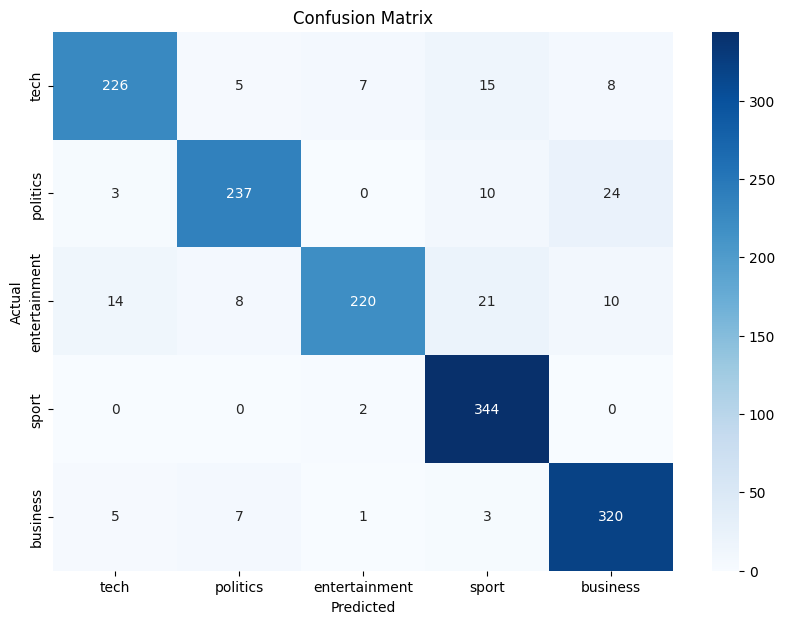

               precision    recall  f1-score   support

         tech       0.88      0.95      0.92       336
     politics       0.96      0.81      0.87       273
entertainment       0.92      0.86      0.89       274
        sport       0.88      0.99      0.93       346
     business       0.91      0.87      0.89       261

     accuracy                           0.90      1490
    macro avg       0.91      0.90      0.90      1490
 weighted avg       0.91      0.90      0.90      1490



In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

actual_categories = train_data['Category']
accuracy = accuracy_score(actual_categories, predicted_categories)
print(f"Accuracy: {accuracy}")

conf_matrix = confusion_matrix(actual_categories, predicted_categories, labels=list(topic_to_category_mapping.values()))

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=topic_to_category_mapping.values(), yticklabels=topic_to_category_mapping.values())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(actual_categories, predicted_categories, target_names=list(topic_to_category_mapping.values()))
print(class_report)

As expected, the NMF performed very well with an accuracy of 90.4%. Looking at the confusion matrix, we can see that there are still pockets of misclassification. Due to the relatively balanced dataset, the precision/recall/f1-score are also relatively balanced, with a healthy score >0.80 across the board.

With that, we will proceed to test it on the test data.

In [33]:
test_data = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')

test_data['clean_text'] = test_data['Text'].apply(lambda x: clean_text(x))

tfidf_test = tfidf_vectorizer.transform(test_data['clean_text'])

nmf_test_output = nmf_model.transform(tfidf_test)

In [34]:
for idx, topic in enumerate(nmf_model.components_):
    print(f"Topic {idx + 1}")
    top_word_indices = topic.argsort()[-10:][::-1]  
    top_words = [feature_names[i] for i in top_word_indices]
    print(", ".join(top_words))
    print("\n")

test_data['Topic'] = nmf_test_output.argmax(axis=1)

predicted_test_categories = [topic_to_category_mapping[topic] for topic in test_data['Topic']]
test_data['Predicted_Category'] = predicted_test_categories

Topic 1
mobile, phone, people, technology, music, service, digital, user, gadget, microsoft


Topic 2
mr, labour, election, blair, party, brown, tory, tax, minister, government


Topic 3
film, award, best, actor, oscar, star, actress, nomination, director, festival


Topic 4
game, england, win, player, wale, ireland, match, cup, team, champion


Topic 5
bn, growth, economy, rate, market, sale, year, bank, economic, price




In [35]:
submission = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': predicted_test_categories
})

submission.head()


,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,sport
3,459,business
4,1020,sport


In [36]:
submission.to_csv('my_submission.csv', index=False)

So the submission received 90.3% accuracy. We will proceed to try improving the model via hyperparameter tuning using GridSearchCV.

Best Model Parameters:
{'beta_loss': 'kullback-leibler', 'l1_ratio': 0, 'max_iter': 200, 'n_components': 5, 'solver': 'mu'}

Accuracy of the best NMF model from grid search: 0.9496644295302014


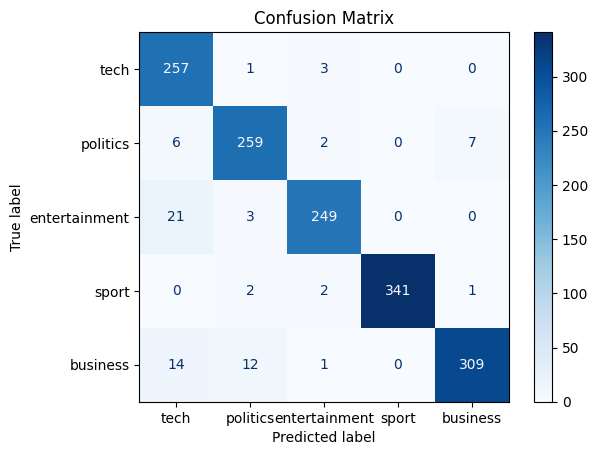

               precision    recall  f1-score   support

         tech       0.97      0.92      0.95       336
     politics       0.97      0.91      0.94       273
entertainment       0.94      0.95      0.94       274
        sport       1.00      0.99      0.99       346
     business       0.86      0.98      0.92       261

     accuracy                           0.95      1490
    macro avg       0.95      0.95      0.95      1490
 weighted avg       0.95      0.95      0.95      1490



In [37]:
from sklearn.model_selection import GridSearchCV

nmf = NMF(random_state=42)
param_grid = {
    'n_components': [5],
    'solver': ['mu'],
    'beta_loss': ['frobenius', 'kullback-leibler'],
    'l1_ratio': [0, 0.5, 1],
    'max_iter': [200]
}

def accuracy_scorer(estimator, X, y):
    topic_matrix = estimator.transform(X)
    topic_indices = topic_matrix.argmax(axis=1)
    predicted_categories = [topic_to_category_mapping[topic] for topic in topic_indices]
    return accuracy_score(y, predicted_categories)

grid_search = GridSearchCV(nmf, param_grid, scoring=accuracy_scorer, cv=5, n_jobs=-1)
grid_search.fit(tfidf_matrix, train_data['Category'])

best_nmf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

nmf_output = best_nmf_model.transform(tfidf_matrix)

predicted_topics = nmf_output.argmax(axis=1)

predicted_categories = [topic_to_category_mapping[topic] for topic in predicted_topics]

accuracy = accuracy_score(train_data['Category'], predicted_categories)

print("Best Model Parameters:")
print(best_params)
print("\nAccuracy of the best NMF model from grid search:", accuracy)

true_labels = train_data['Category']
predicted_labels = [topic_to_category_mapping[topic] for topic in predicted_topics]

matrix = confusion_matrix(true_labels, predicted_labels, labels=list(topic_to_category_mapping.values()))

cmd = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(topic_to_category_mapping.values()))

cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

report = classification_report(true_labels, predicted_labels, target_names=list(topic_to_category_mapping.values()))
print(report)

Apologies that this part is a bit complicated. Here, a custom scoring function considers the topic-to-category mapping to calculate how many categories the model predicted correctly. I guess its neater than what i did for initial model with manual adjustment.

After the Grid Search, the best set of hyperparameters are the 'kullback-leibler' distance function, an 'l1_ratio' of 0 (indicating no regularization). The accuracy of the best model from the grid search was approximately 95.0%, showing an improvement from the base model. Looking at the confusion matrix, we can also see the improvement as more articles are classified within the 5 categories and lesser articles classified incorrectly. Across the F1 scores, we also see consistently >5% improvement across the categories.

Lets try it on the test data via submission with this improved model.


In [18]:
nmf_test_output = best_nmf_model.transform(tfidf_test)

test_topic_assignments = nmf_test_output.argmax(axis=1)

predicted_test_categories = [topic_to_category_mapping[topic] for topic in test_topic_assignments]

test_data['Predicted_Category'] = predicted_test_categories

submission1 = pd.DataFrame({
    'ArticleId': test_data['ArticleId'],
    'Category': predicted_test_categories
})

print(submission1.head())

submission1.to_csv('my_best_model_submission.csv', index=False)


   ArticleId  Category
0       1018     sport
1       1319      tech
2       1138     sport
3        459  business
4       1020     sport


With the hyperparameter tuning, the accuracy for test data this time is 96.3%. Which indeed shows an improvement after tuning the model.

# Compare with supervised learning

For the comparison with supervised learning, i will be utilising SVM for modeling.

In [19]:
from sklearn.svm import SVC

X_train = tfidf_matrix  
y_train = train_data['Category']

svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

y_pred_train = svm_classifier.predict(X_train)

train_accuracy = accuracy_score(y_train, y_pred_train)
print(f'Training Accuracy: {train_accuracy}')

X_test = tfidf_test

y_pred_test = svm_classifier.predict(X_test)

submission_svm = test_data[['ArticleId']].copy()  
submission_svm['Category'] = y_pred_test
submission_svm.to_csv('submission_svm.csv', index=False)


Training Accuracy: 0.9986577181208054


With the training accuracy at an impressive 99.9%, the submission received 98.2 for test accuracy. Truly impressive compared to the NMF method (even with hyperparameter tuned). Lets continue by changing the train data size before discussing the comparison in full.

In [20]:
from sklearn.model_selection import train_test_split

X_full_train = tfidf_matrix
y_full_train = train_data['Category']

X_full_test = tfidf_test

train_sizes = [0.5, 0.2, 0.1]

for size in train_sizes:
    _, X_train_subset, _, y_train_subset = train_test_split(
        X_full_train, 
        y_full_train, 
        train_size=size,
        random_state=42,
        stratify=y_full_train
    )

    svm_classifier = SVC(kernel='linear')
    svm_classifier.fit(X_train_subset, y_train_subset)
    
    y_pred_train = svm_classifier.predict(X_train_subset)
    train_accuracy = accuracy_score(y_train_subset, y_pred_train)
    print(f'Training accuracy with {size*100}% of data: {train_accuracy}')
    
    y_pred_test = svm_classifier.predict(X_full_test)

    submission = test_data[['ArticleId']].copy()
    submission['Category'] = y_pred_test
    filename = f'submission_svm_{int(size*100)}_percent.csv'
    submission.to_csv(filename, index=False)

Training accuracy with 50.0% of data: 1.0
Training accuracy with 20.0% of data: 0.9983221476510067
Training accuracy with 10.0% of data: 0.9992542878448919


Even with the decreased train data size, the submitted test results were impressive for SVM models - 10% (99.9% accuracy), 20% (99.8% accuracy) and 100% (98.0% accuracy). We will now test the same for NMF models across different train data size.

In [21]:
X_full = tfidf_matrix
y_full = train_data['Category']

X_test_full = tfidf_test

train_sizes = [0.5, 0.2, 0.1]

best_params = {'beta_loss': 'kullback-leibler', 'l1_ratio': 0, 'max_iter': 200, 'n_components': 5, 'solver': 'mu'}

for size in train_sizes:
    # Split the training data according to the current size
    _, X_train_subset, _, y_train_subset = train_test_split(
        X_full, 
        y_full, 
        train_size=size,  
        random_state=42,
        stratify=y_full 
    )

    nmf_model = NMF(
        n_components=best_params['n_components'],
        init='random',
        solver=best_params['solver'],
        beta_loss=best_params['beta_loss'],
        max_iter=best_params['max_iter'],
        l1_ratio=best_params['l1_ratio'],
        random_state=42
    )
    nmf_model.fit(X_train_subset, y_train_subset)

    nmf_output = nmf_model.transform(X_train_subset)
    predicted_topics = nmf_output.argmax(axis=1)
    predicted_categories = [topic_to_category_mapping[topic] for topic in predicted_topics]

    train_accuracy = accuracy_score(y_train_subset, predicted_categories)
    print(f'Training accuracy with {size*100}% of data: {train_accuracy}')

    nmf_test_output = nmf_model.transform(X_test_full)
    test_topic_assignments = nmf_test_output.argmax(axis=1)
    predicted_test_categories = [topic_to_category_mapping[topic] for topic in test_topic_assignments]

    submission_nmf = pd.DataFrame({
        'ArticleId': test_data['ArticleId'],
        'Category': predicted_test_categories
    })
    filename = f'submission_nmf_{int(size*100)}_percent.csv'
    submission_nmf.to_csv(filename, index=False)

    print(f"Submission file '{filename}' has been saved.")

Training accuracy with 50.0% of data: 0.16375838926174496
Submission file 'submission_nmf_50_percent.csv' has been saved.
Training accuracy with 20.0% of data: 0.05201342281879195
Submission file 'submission_nmf_20_percent.csv' has been saved.
Training accuracy with 10.0% of data: 0.013422818791946308
Submission file 'submission_nmf_10_percent.csv' has been saved.


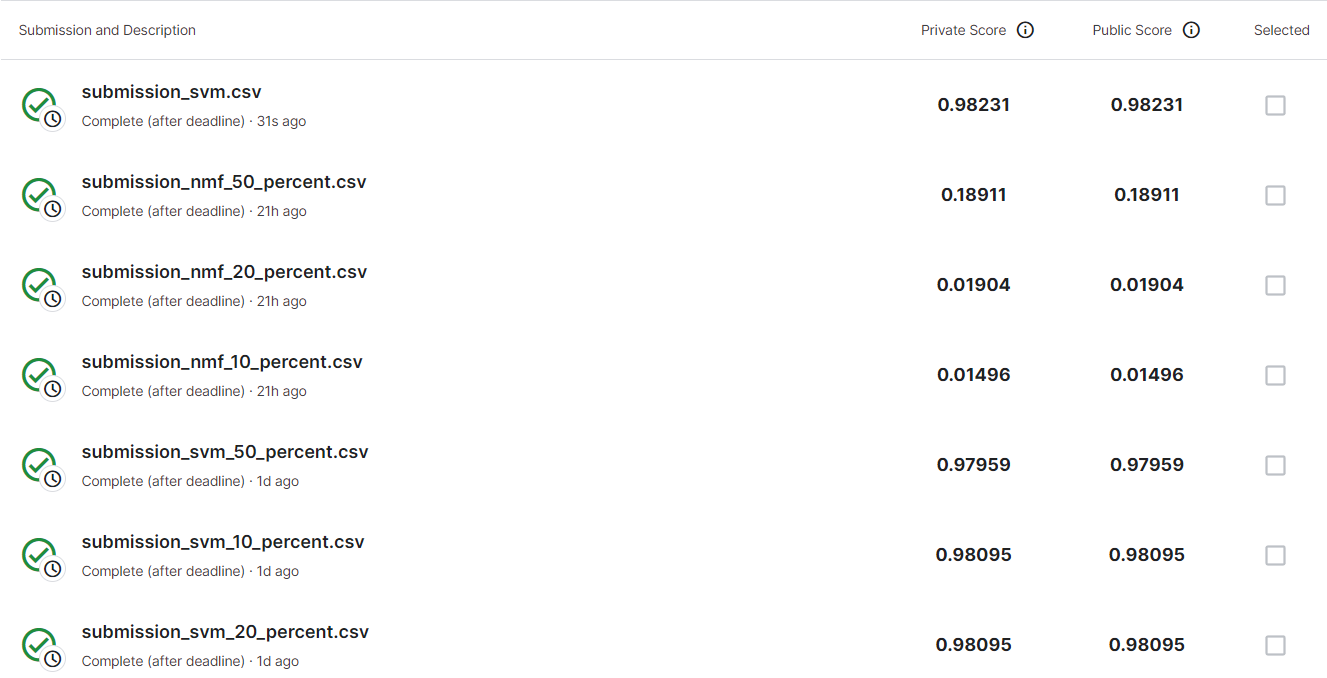

In total, 6 models were trained - 3 SVM and 3 NMF at 10%, 20% and 50% training data size. The table above shows the summary of all test results submitted while the 2 outputs above that highlights the training accuracies across SVM and NMF models at different training sizes. (Ignore the top one as i needed to submit one to get to the page)

After submitting the test results for NMF at different train size, the results returned poorly as expected after seeing the poor training accuracy. Test - 10% (15.0% accuracy), 20% (19.0% accuracy) and 50% (19.0% accuracy). As compared to the SVM models, it is a clear distinction as all of the models, even the one with 10% training data score have high 90s % accuracies.

First, it is clear that NMF perform poorly as training data size decreases. With less data, NMF might not have enough information to establish the patterns and structures it typically identifies in richer data. This limitation is particularly pronounced in text analysis, where the context and semantic structures require substantial data to be understood - as in our topic modeling through these articles.

On the other hand, the SVM shows excellent performance, even with a reduced amount of data up till 10% of train data size. This suggest that it can find a hyperplane that almost perfectly separates the different topics across the articles. The SVM is the one that is data-efficient because the accuracy doesn't decrease much with reduced data, which suggests that the essential patterns in the data are still present and that SVM is using these features effectively.

The fact that SVM is scoring a perfect or near-perfect score on the training data suggests that the model could be overfitting, especially considering the >99% accuracy with 10% of the data. While it's learning the training data very well, there's a risk that it's not generalizing to unseen data. Although this is less of a concern in this particular dataset, it might pose a risk in other settings - e.g. across blogs that varies widely in topics and writing styles/languages.